In [1]:
'''
Notebook that calculates SaO2 decreasement over 4% and compare with 'oahi' from dataset.
Test for around 500 edf files.

Result: Correlation is about 0.86. Strong correlated.
'''
# import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyedflib
import scipy.signal
import scipy.stats
import random
import os

In [2]:
# helper function to merge two lists
def insort(a, b, kind='mergesort'):
    '''
    A function to merge two arrays and sort
    https://stackoverflow.com/questions/12427146/combine-two-arrays-and-sort
    '''
    # took mergesort as it seemed a tiny bit faster for my sorted large array try.
    c = np.concatenate((a, b)) # we still need to do this unfortunatly.
    c.sort(kind=kind)
    flag = np.ones(len(c), dtype=bool)
    np.not_equal(c[1:], c[:-1], out=flag[1:])
    return c[flag]

In [12]:
pwd = os.getcwd()+'/test_edf'
files = sorted(os.listdir(pwd))

In [4]:
final_result = {}
counter = 0
print_every = 20
for file in files:
    # load edf file
    g = None # initialize as None
    g = pyedflib.EdfReader(pwd+file)
    n = g.signals_in_file
    signal_labels = g.getSignalLabels()
    sleep_time = g.getFileDuration()
    sigbufs = [[] for n in range(n)]
    for i in np.arange(n):
        sigbufs[i] = g.readSignal(i)
    # find and extract SaO2 channel
    SaO2Idx = signal_labels.index('SaO2')
    SaO2 = sigbufs[SaO2Idx]

    # remove spikes, SaO2 < 70%
    SaO2 = SaO2[SaO2 >= 70]
    
    # smooth data, use Savitzky–Golay filter, with window size = 17 and polyorder = 4
    window_size = 17
    polyorder = 4

    smooth_SaO2 = scipy.signal.savgol_filter(SaO2, window_size, polyorder)
    
    # calculate local extrema
    n = 5 #find local extrema among 6 points
    local_max = scipy.signal.argrelextrema(smooth_SaO2, np.greater, order = n)[0]
    local_min = scipy.signal.argrelextrema(smooth_SaO2, np.less, order = n)[0]
    
    merge_list = insort(local_max, local_min)
    
    '''
    a naive way to calculate SaO2 decreasement
    '''
#     result = []
#     for i in range(len(merge_list) - 2):
#         if merge_list[i] in local_max and merge_list[i+1] in local_min:
#             diff = smooth_SaO2[merge_list[i]] - smooth_SaO2[merge_list[i+1]]
#             result.append(diff)

    '''
    Improved way to calculate decreasement
    start from maximum, suppose SaO2 is normal in the beginning
    if point i is max, and point i+1 is min, and point i+2 is max, then calcualte difference
    if point i is max, and point i+i, i+2,...,i+n are also max, calculate biggest number, i+c
    now if i+n+1 is min, i+n+2, i+n+3,...,i+n+m are also min, calculate smallest number, i+c+d
    calculate difference between SaO2[i+c+d] - SaO2[i+c], next point to start is i+n+m+1
    '''
    result = []
    i = 0
    while i < len(merge_list):
        if merge_list[i] in local_max:
            max_temp = smooth_SaO2[merge_list[i]]
            min_temp = max_temp
            max_counter = 0
            min_counter = 0
            max_location = i
            min_location = i
            # check the bound
            if i + max_counter >= len(merge_list) - 1:
                break
            
            while merge_list[i + max_counter] in local_max:
                if smooth_SaO2[merge_list[i + max_counter]] >= max_temp:
                    max_temp = smooth_SaO2[merge_list[i + max_counter]] #find the biggest number
                    max_location = i + max_counter #find the location of biggest number
                max_counter += 1
            
                #check the bound
                if i + max_counter >= len(merge_list) - 1:
                    break
            #print('largest is', max_temp, ' Position is', merge_list[max_location])
        
            #calculate the min, same as max
            while i + max_counter + min_counter < len(merge_list) and merge_list[i + max_counter + min_counter] in local_min:
                if smooth_SaO2[merge_list[i + max_counter + min_counter]] <= min_temp:
                    min_temp = smooth_SaO2[merge_list[i + max_counter + min_counter]]
                    min_location = i + max_counter + min_counter
                min_counter += 1
        
            #print('smallest is', min_temp, ' Position is', merge_list[min_location])
        
            # calculate the diff
            diff = max_temp - min_temp
            result.append(diff)
        
            #update pointer
            i = i + max_counter + min_counter
        else:
            i += 1
    
    
    result = np.asarray(result)
    over4 = result[result > 4]
    score = (60 * len(over4)) / (sleep_time / 60)
    final_result[file] = score
    
    counter += 1
    if counter % print_every == 0:
        print(counter, 'done.')

20 done.
40 done.
60 done.
80 done.
100 done.
120 done.
140 done.
160 done.
180 done.
200 done.
220 done.
240 done.
260 done.
280 done.
300 done.
320 done.
340 done.
360 done.
380 done.
400 done.
420 done.


In [5]:
f = open('score', 'r')
truth = f.read()
f.close()
truth = truth.splitlines()
truth = [float(i) for i in truth]

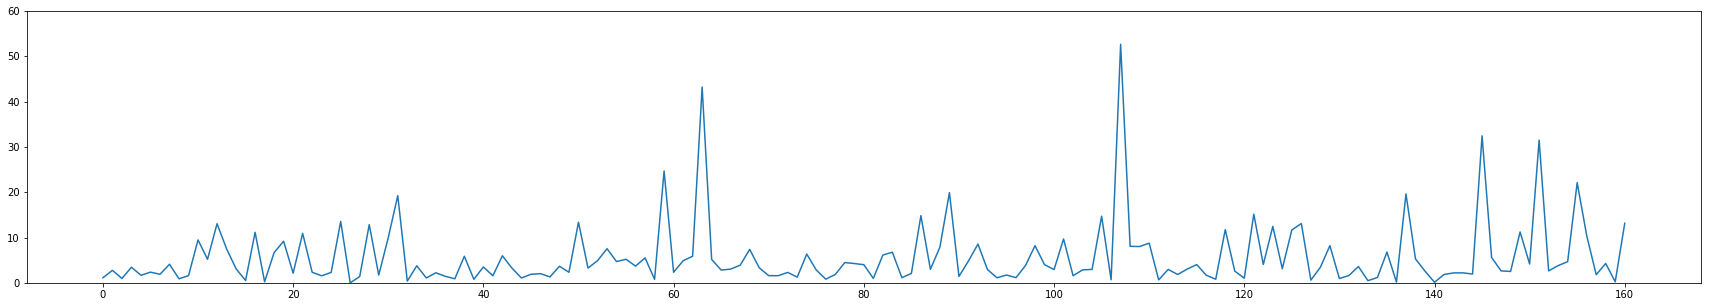

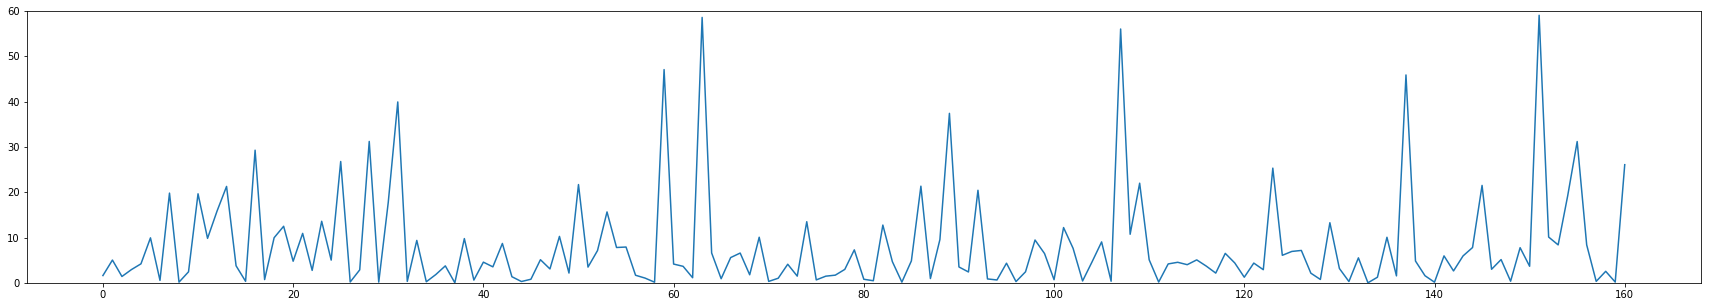

In [12]:
## result for ~200 files
plt.figure(figsize=(30,5))
plt.plot(final_result.values())
plt.ylim(0, 60) 
plt.show()

plt.figure(figsize=(30,5))
plt.plot(truth)
plt.ylim(0, 60) 
plt.show()

In [17]:
# ~200 files
# calculate correlation, use Pearson’s Correlation
corr, _ = scipy.stats.pearsonr(list(final_result.values()), truth)
print('Correlation is: ',corr)

Correlation is:  0.867735961217816


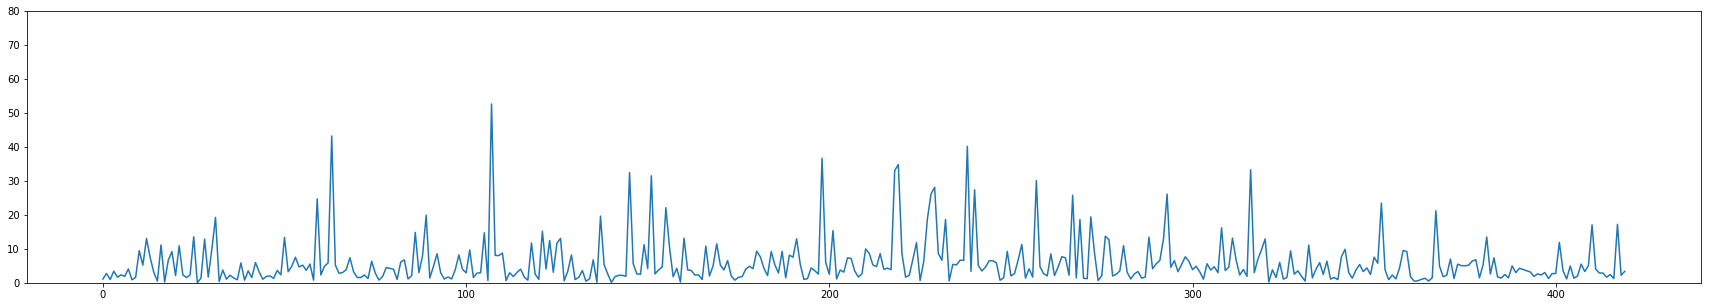

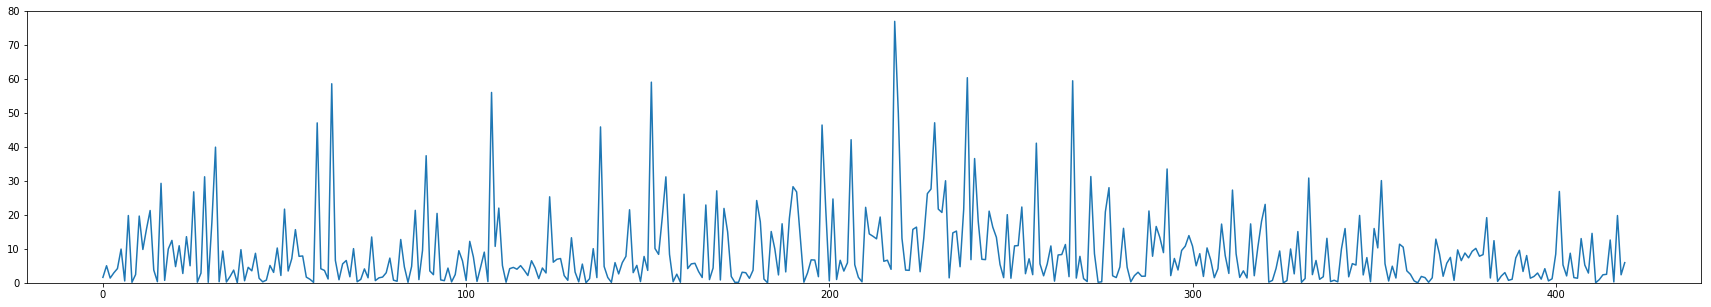

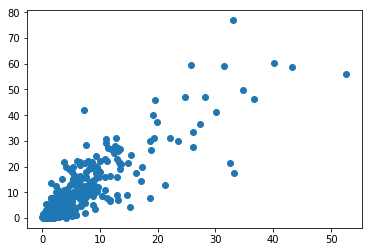

Correlation is:  0.8594997933504274
p-value is:  6.6797288389370854e-124


In [55]:
# result for ~500 files
plt.figure(figsize=(30,5))
plt.plot(final_result.values())
plt.ylim(0, 80) 
plt.show()

plt.figure(figsize=(30,5))
plt.plot(truth)
plt.ylim(0, 80) 
plt.show()

plt.scatter(final_result.values(), truth)
plt.show()

# calculate correlation, use Pearson’s Correlation
corr, p = scipy.stats.pearsonr(list(final_result.values()), truth)
print('Correlation is: ',corr)
print('p-value is: ',p)

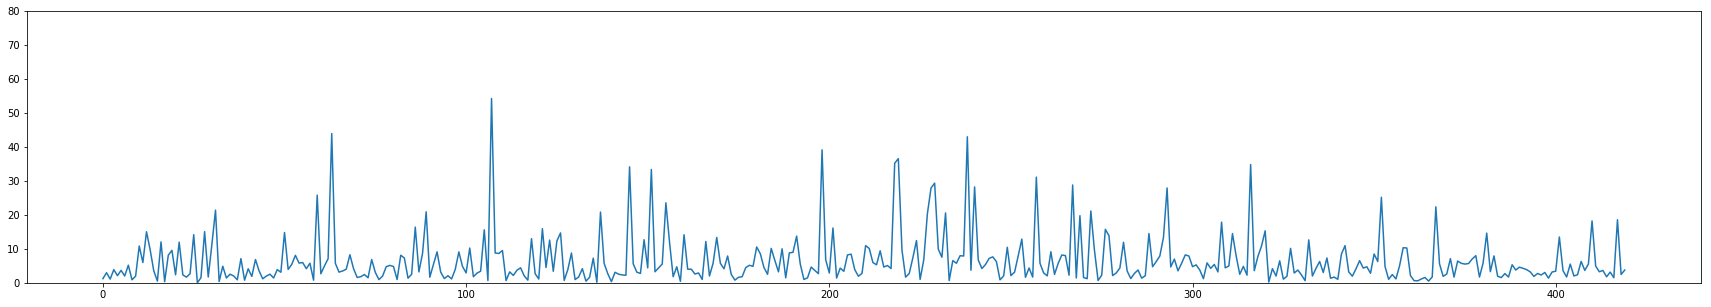

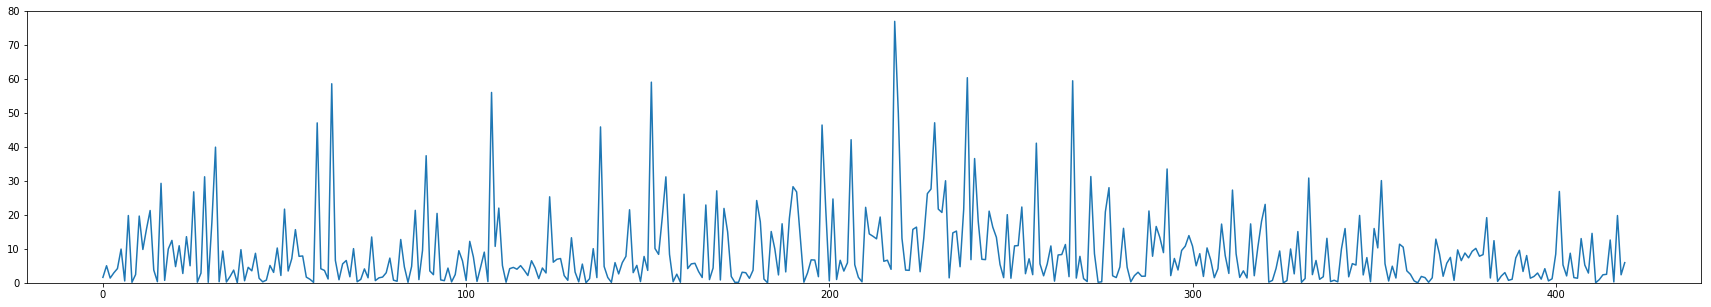

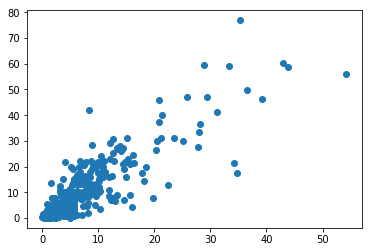

Correlation is:  0.8675716618350675
p-value is:  6.972884326559203e-129


In [9]:
# result for ~500 files, with improved algorithm
plt.figure(figsize=(30,5))
plt.plot(final_result.values())
plt.ylim(0, 80) 
plt.show()

plt.figure(figsize=(30,5))
plt.plot(truth)
plt.ylim(0, 80) 
plt.show()

plt.scatter(final_result.values(), truth)
plt.show()

# calculate correlation, use Pearson’s Correlation
corr, p = scipy.stats.pearsonr(list(final_result.values()), truth)
print('Correlation is: ',corr)
print('p-value is: ',p)

In [17]:
# helper function to check file difference
pwd = os.getcwd()+'/test_edf'
files = sorted(os.listdir(pwd))

name_check = [s.replace('shhs1-', '') for s in files]
name_check = [s.replace('.edf', '') for s in name_check]


h = open('correct_files', 'r')
file_names = h.read()
h.close()
file_names = file_names.splitlines()
print(list(set(file_names) - set(name_check)))

['200246', '200279']
